<a href="https://colab.research.google.com/github/geersenthil/Topic-Modeling-/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [ ]:
pip install pyLDAvis


In [ ]:
import re
import pandas as pd
import numpy as np
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string


#for histogram
import matplotlib.pyplot as plt
from collections import Counter

#nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


#Dataset
from sklearn.datasets import fetch_20newsgroups

#Spacy
import spacy
nlp = spacy.load('en_core_web_sm')

#Visuals
import pyLDAvis
import pyLDAvis.gensim_models

#warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Data into Dataframe

In [ ]:
#method that converts data to csv file
# def twenty_newsgroup_data_to_csv():
#     news_group_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes') ,shuffle=True)

#     df = (pd.DataFrame([news_group_data.data, news_group_data.target.tolist()]).T).sample(1500)
#     df.columns = ['text', 'target']

#     targets = pd.DataFrame( news_group_data.target_names)
#     targets.columns=['title']

#     out = pd.merge(df, targets, left_on='target', right_index=True)
#     out.to_csv('20_newsgroup.csv')
# twenty_newsgroup_data_to_csv()


In [ ]:
#read data from CSV
dataset = pd.read_csv('20_newsgroup_sample.csv', delimiter=',')
dataset.dropna(subset = ["text"], inplace=True)

In [ ]:
# Data Size
print("The size of the dataset is: \n", dataset.count())

The size of the dataset is: 
 Unnamed: 0    1463
text          1463
target        1463
title         1463
dtype: int64


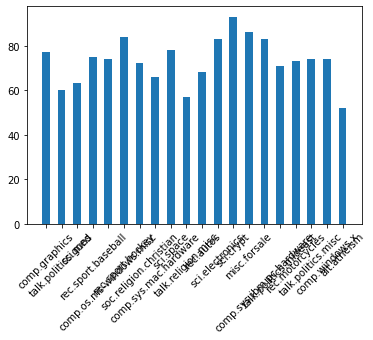

In [ ]:
#Category Distribution
counter = Counter(dataset['title'])
topic_names = counter.keys()
topic_counts = counter.values()
ax = plt.gca()
plt.draw()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(topic_names))
width = 0.5
plt.bar(indexes, topic_counts, width)

ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.xticks(indexes, topic_names)
plt.show()

In [ ]:
print(counter)

Counter({'sci.crypt': 93, 'misc.forsale': 86, 'rec.sport.hockey': 84, 'sci.electronics': 83, 'comp.sys.ibm.pc.hardware': 83, 'sci.space': 78, 'comp.graphics': 77, 'rec.sport.baseball': 75, 'comp.os.ms-windows.misc': 74, 'talk.politics.misc': 74, 'comp.windows.x': 74, 'rec.motorcycles': 73, 'soc.religion.christian': 72, 'talk.politics.mideast': 71, 'rec.autos': 68, 'comp.sys.mac.hardware': 66, 'sci.med': 63, 'talk.politics.guns': 60, 'talk.religion.misc': 57, 'alt.atheism': 52})


### Pre-process data

Lemmatization to get base words

In [ ]:
def lemmatization(texts, allowed_postags=["NOUN","ADJ","VERB","ADV"]):
  nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
  texts_out = []
  for text in texts:
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    texts_out.append(final)
  return (texts_out)
 

In [ ]:
dataset['news_lemma_text']=lemmatization(dataset['text'])


In [ ]:
dataset.sample(10)


,Unnamed: 0,text,target,title,news_lemma_text
1322,10604,"\n\n\nGarrett, you are a really pathetic liar....",18,talk.politics.misc,really pathetic liar charge arguable most obvi...
1059,8691,Finally a fax service to all Internet users in...,6,misc.forsale,finally fax service internet user continental ...
834,8141,I recently bought an apparantly complete Expan...,12,sci.electronics,recently buy apparantly complete consist box c...
731,3833,"I saw an interesting product in NY Auto Show, ...",7,rec.autos,see interesting product would like hear commen...
1084,5628,I am looking at buying some Companion brand VL...,3,comp.sys.ibm.pc.hardware,look buy brand motherboard chipset experience ...
491,9283,pwhite@empros.com (Peter White) relates a stor...,15,soc.religion.christian,relate story person give message tongue consis...
1063,4912,Here it is\n\nZoom 14.4k FAX/DATA v.32bis mod...,6,misc.forsale,here modem evreythe only purchase Will happily...
680,7599,"Long time, no see.\n\n\t\t\tAndreas\n\n-- \n\n...",19,talk.religion.misc,long time siberian
127,7050,The FBI released large amounts of CS tear gas ...,16,talk.politics.guns,release large amount tear gas compound tear ga...
922,9598,Don't get fooled by exponents 2^80 (possible k...,11,sci.crypt,fool exponent ^ possible key same league parti...


Remove Stopwords

In [ ]:
stop_words = stopwords.words('english')
print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use','cdw','would','line','article'])
print(len(stop_words))

179
188


In [ ]:
#tokenize
def gen_words(texts):
  final = []

  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    for w in new:
      if w in stop_words or len(w)<3:
        new.remove(w)
    final.append(new)
  return (final)
dataset['news_tokens']=gen_words(dataset['news_lemma_text'])


In [ ]:
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens
1417,8112,\nxdm does XGrabServer when it's running in se...,5,comp.windows.x,when run secure mode so screen lock really sim...,"[run, secure, mode, screen, lock, really, simp..."
1154,3342,"From _Myths and Facts_, by Leonard J. Davis, N...",17,talk.politics.mideast,almost exclusive focus civilian target troup g...,"[almost, exclusive, focus, civilian, target, t..."
301,978,Has anyone had experience with the new Greenle...,2,comp.os.ms-windows.misc,experience new can even demo winterm run baud ...,"[experience, new, even, demo, winterm, run, ba..."
342,1040,I installed Windows for Workgroups on my netwo...,2,comp.os.ms-windows.misc,instal network have problem mapping drive file...,"[instal, network, problem, mapping, drive, fil..."
492,3452,"Dear fellow netters,\n\nFrom time to time a te...",15,soc.religion.christian,dear fellow netter time time term similar occu...,"[dear, fellow, netter, time, time, term, simil..."
851,695,\nRefer to patents by JAMES HARRIS ROGERS:\n95...,12,sci.electronics,refer patent roger detail method underground u...,"[refer, patent, roger, detail, method, undergr..."
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...,"[recently, instal, system, base, non, linear, ..."
1443,8987,>When some types of client windows are displa...,5,comp.windows.x,when type client window display part window wr...,"[type, client, window, display, part, window, ..."
373,3795,\n\tThe South Florida Colons.\n\n\t:)\n,10,rec.sport.hockey,,[]
1172,9983,"You definetly are in need of a shrink, loser!",17,talk.politics.mideast,definetly need shrink loser,"[definetly, need, shrink, loser]"


## Bag of words

In [ ]:
#id2word
data_word = dataset['news_tokens']
id2word = corpora.Dictionary(data_word)
corpus = []
for text in data_word:
  new = id2word.doc2bow(text)
  corpus.append(new)

#id and frequency of word
print ("Dictionary for doc 9" ,corpus[9])
print ("Dictionary for doc 176" ,corpus[176])


Dictionary for doc 9 [(0, 2), (6, 1), (8, 1), (16, 1), (22, 11), (53, 2), (58, 1), (62, 1), (78, 1), (86, 2), (98, 2), (99, 1), (110, 1), (111, 1), (121, 1), (122, 1), (125, 1), (126, 1), (127, 2), (134, 2), (159, 1), (178, 1), (196, 1), (209, 1), (212, 1), (222, 1), (227, 2), (229, 2), (231, 2), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 2), (239, 1), (240, 1), (241, 1), (242, 2), (243, 1), (244, 1), (245, 1), (246, 1), (247, 1), (248, 1), (249, 2), (250, 1), (251, 1), (252, 3), (253, 4), (254, 1), (255, 1), (256, 1), (257, 5), (258, 1), (259, 1), (260, 4), (261, 1), (262, 1), (263, 2), (264, 1), (265, 1), (266, 1), (267, 2), (268, 1), (269, 1), (270, 1), (271, 1), (272, 1), (273, 2), (274, 1), (275, 1), (276, 2), (277, 3), (278, 1), (279, 1), (280, 1), (281, 1), (282, 1), (283, 1), (284, 1), (285, 1), (286, 1), (287, 1), (288, 4), (289, 1), (290, 1), (291, 1), (292, 2), (293, 1), (294, 3), (295, 1), (296, 1), (297, 4), (298, 4), (299, 1), (300, 1), (301, 1), (3

In [ ]:
word = id2word[298]
print(word)

point


## Build LDA Model

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word = id2word, num_topics = 20, random_state = 100, update_every=1, chunksize=100, passes = 10, alpha="auto")

## Visualise Data

In [ ]:
# Build LDA model

# lda_modelF = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=21)
for i in range(0, lda_model.num_topics):
  print ("Topic" , i , lda_model.print_topic(i))

Topic 0 0.035*"say" + 0.028*"people" + 0.025*"know" + 0.022*"think" + 0.016*"want" + 0.013*"come" + 0.013*"could" + 0.013*"take" + 0.012*"believe" + 0.012*"tell"
Topic 1 0.038*"encryption" + 0.024*"secure" + 0.019*"remark" + 0.015*"press" + 0.014*"timing" + 0.014*"escrow" + 0.013*"reader" + 0.013*"sexual" + 0.012*"agreement" + 0.011*"compiler"
Topic 2 0.039*"page" + 0.038*"attempt" + 0.037*"action" + 0.025*"approach" + 0.021*"sys" + 0.018*"industry" + 0.018*"intelligence" + 0.016*"economy" + 0.015*"development" + 0.015*"frequently"
Topic 3 0.048*"bike" + 0.026*"gas" + 0.024*"assistance" + 0.017*"motorcycle" + 0.014*"air" + 0.014*"mechanism" + 0.012*"desire" + 0.012*"totally" + 0.011*"tear" + 0.011*"daughter"
Topic 4 0.023*"government" + 0.018*"make" + 0.014*"man" + 0.014*"fact" + 0.012*"law" + 0.012*"exist" + 0.010*"right" + 0.010*"people" + 0.009*"religion" + 0.009*"way"
Topic 5 0.018*"job" + 0.016*"power" + 0.012*"young" + 0.012*"woman" + 0.012*"get" + 0.011*"take" + 0.011*"hand" + 0

In [ ]:
x=lda_model.show_topics()

twords={}
for topic,word in x:
    twords[topic]=re.sub('[^A-Za-z ]+', '', word)
print(twords)

{10: 'border  pixmap  middle  header  repaint  mydisplay  lens  projector  lense  detailwin', 9: 'generation  review  grain  mouse  following  bind  ram  meg  test  din', 13: 'rider  widget  weekend  medium  risk  indonesian  screw  ax  plant  enjoy', 8: 'existence  exist  concern  meet  stay  listen  fax  publish  theory  extend', 1: 'encryption  secure  remark  press  timing  escrow  reader  sexual  agreement  compiler', 15: 'work  sense  fund  client  window  end  new  little  figure  actually', 16: 'file  program  entry  information  system  server  section  internet  run  version', 4: 'government  make  man  fact  law  exist  right  people  religion  way', 17: 'well  may  see  good  make  much  year  post  way  key', 0: 'say  people  know  think  want  come  could  take  believe  tell'}


Best Topic

In [ ]:
def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return(sub_li)

def best_topic():
  num=0
  arr =[]
  topicWords =[]
  for x in corpus:
    match = lda_model[x]
    #print(match)
    # sort by match 
    new_vector = Sort(match)
    
    print("For Doc #",num,"the best topic is", [i[0] for i in new_vector][0])
    setVal = [j[0] for j in new_vector][0]
    arr.append(setVal)
    topicWords.append(twords.get(setVal))
    num =num+1
  dataset['best_topic_lda']=arr
  dataset['best_topic_lda_words']=topicWords

best_topic()

For Doc # 0 the best topic is 19
For Doc # 1 the best topic is 17
For Doc # 2 the best topic is 9
For Doc # 3 the best topic is 0
For Doc # 4 the best topic is 17
For Doc # 5 the best topic is 7
For Doc # 6 the best topic is 0
For Doc # 7 the best topic is 16
For Doc # 8 the best topic is 11
For Doc # 9 the best topic is 17
For Doc # 10 the best topic is 0
For Doc # 11 the best topic is 8
For Doc # 12 the best topic is 4
For Doc # 13 the best topic is 4
For Doc # 14 the best topic is 17
For Doc # 15 the best topic is 2
For Doc # 16 the best topic is 15
For Doc # 17 the best topic is 0
For Doc # 18 the best topic is 7
For Doc # 19 the best topic is 19
For Doc # 20 the best topic is 16
For Doc # 21 the best topic is 0
For Doc # 22 the best topic is 0
For Doc # 23 the best topic is 15
For Doc # 24 the best topic is 8
For Doc # 25 the best topic is 12
For Doc # 26 the best topic is 4
For Doc # 27 the best topic is 11
For Doc # 28 the best topic is 16
For Doc # 29 the best topic is 16
For D

In [ ]:
dataset.head(100)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,best_topic_lda,best_topic_lda_words
1,5384,I would like a reference to an algorithm that ...,1,comp.graphics,would like reference algorithm can detect clos...,"[like, reference, algorithm, detect, closed, c...",19,None
2,10443,\n\nHere at Lewis and Clark College we have re...,1,comp.graphics,here recently instal system base non - linear ...,"[recently, instal, system, base, non, linear, ...",17,well may see good make much year post ...
3,6305,\nI went back and looked at the review again. ...,1,comp.graphics,go back look review again claim significant di...,"[back, look, review, claim, significant, diffe...",9,generation review grain mouse following b...
4,6583,"\n-> According to the TIFF 5.0 Specification, ...",1,comp.graphics,accord version number choose deep philosophica...,"[accord, version, number, choose, deep, philos...",0,say people know think want come could t...
5,7849,re: majority of users not readding from floppy...,1,comp.graphics,majority user readde how cd rom would like use...,"[majority, user, readde, cd, rom, like, fast, ...",17,well may see good make much year post ...
...,...,...,...,...,...,...,...,...
98,11070,\n\nSo where was she? And would she consider ...,16,talk.politics.guns,where would consider stay there,"[would, consider, stay]",0,say people know think want come could t...
99,4068,\n\nBut whatever the neutrons hit has a good c...,16,talk.politics.guns,neutron hit good chance absorb neutron become ...,"[neutron, hit, good, chance, absorb, neutron, ...",4,government make man fact law exist right...
100,3685,"The ATF agent interviewed on ""Street Stories"" ...",16,talk.politics.guns,agent interview report raid plan go ahead even...,"[agent, interview, report, raid, plan, ahead, ...",0,say people know think want come could t...
101,1332,That was the entire point to *you*. What ex...,16,talk.politics.guns,entire point exactly claim hear eye witness de...,"[entire, point, exactly, claim, hear, eye, wit...",0,say people know think want come could t...


## Cosine Similarity

In [ ]:
# get original topic words
dataset['target_topic_word']= dataset['title'].str.split('.')
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,best_topic_lda,best_topic_lda_words,target_topic_word
268,9345,"\nwrites a ""Who woulda thunk it"" article which...",9,rec.sport.baseball,write woulda thunk article really same piece t...,"[write, woulda, thunk, really, piece, time, th...",0,say people know think want come could t...,"[rec, sport, baseball]"
6,1156,Hi Everyone--\n\n It's spend-the-money-before...,1,comp.graphics,spend money go time here need find pc base sof...,"[spend, money, time, need, find, base, softwar...",7,None,"[comp, graphics]"
1192,7222,\n\nThis newsgroup is for intelligent discussi...,17,talk.politics.mideast,newsgroup intelligent discussion want smarten ...,"[newsgroup, intelligent, discussion, want, sma...",4,government make man fact law exist right...,"[talk, politics, mideast]"
26,5933,\nHow does that compare with JPEG on the same ...,1,comp.graphics,how compare same image hardware as far size sp...,"[compare, image, hardware, far, size, speed, i...",12,None,"[comp, graphics]"
204,7079,"Following a series of miscarriages, my wife wa...",13,sci.med,follow series miscarriage wife give transfusio...,"[follow, series, miscarriage, wife, give, tran...",6,None,"[sci, med]"
450,10462,\n\nThere is another way to view this. The Tr...,15,soc.religion.christian,way view true celebration true foundation worl...,"[way, view, true, celebration, true, foundatio...",6,None,"[soc, religion, christian]"
296,313,"\n\n\n\n\nYou do mean disks, don't you, not ta...",2,comp.os.ms-windows.misc,mean disk tape forgot say look old new just us...,"[mean, disk, tape, forgot, say, look, old, new...",0,say people know think want come could t...,"[comp, os, ms-windows, misc]"
611,9518,\n\nThe gravity data is collected in real-time...,14,sci.space,gravity datum collect real time record tape re...,"[gravity, datum, collect, real, time, record, ...",16,file program entry information system ser...,"[sci, space]"
877,9027,\nThey require two separate grounds. One grou...,12,sci.electronics,require separate ground ground go ground pin o...,"[require, separate, ground, ground, ground, pi...",4,government make man fact law exist right...,"[sci, electronics]"
327,2989,What files do I need to download for GhostScri...,2,comp.os.ms-windows.misc,file need download never use before file gs252...,"[file, need, download, never, before, file, wi...",16,file program entry information system ser...,"[comp, os, ms-windows, misc]"


In [ ]:
dataset['best_topic_lda_words_arr']= dataset['best_topic_lda_words'].str.split()
dataset.sample(10)

,Unnamed: 0,text,target,title,news_lemma_text,news_tokens,best_topic_lda,best_topic_lda_words,target_topic_word,best_topic_lda_words_arr
84,9116,"\nCS ""tear-gas"" was used in Vietnam because it...",16,talk.politics.guns,tear gas use make wretch so hard stomach come ...,"[tear, gas, make, wretch, hard, stomach, come,...",3,None,"[talk, politics, guns]",None
1377,9422,Archive-name: Intel-Unix-X-faq\nLast-modified:...,5,comp.windows.x,archive name faq last modify note major re - o...,"[archive, name, faq, last, modify, note, major...",16,file program entry information system ser...,"[comp, windows, x]","[file, program, entry, information, system, se..."
110,6792,"\nFor me, it would be an obvious choice: Armed...",16,talk.politics.guns,would obvious choice armed self defence clearl...,"[obvious, choice, armed, self, defence, clearl...",4,government make man fact law exist right...,"[talk, politics, guns]","[government, make, man, fact, law, exist, righ..."
520,4971,Could someone please send instructions for ins...,4,comp.sys.mac.hardware,Could send instruction instal simms vram jmk13...,"[could, send, instruction, instal, simms, vram...",0,say people know think want come could t...,"[comp, sys, mac, hardware]","[say, people, know, think, want, come, could, ..."
626,10530,"\n\n\n\n\nI don't have to ""try reading a bit"",...",14,sci.space,try read bit work government contractor know r...,"[try, read, bit, work, government, contractor,...",17,well may see good make much year post ...,"[sci, space]","[well, may, see, good, make, much, year, post,..."
1273,5632,"\nEr, without a bike (Ed, maybe you ought to r...",8,rec.motorcycles,bike maybe ought respond how go there go cage ...,"[bike, maybe, ought, respond, go, go, cage, ge...",5,None,"[rec, motorcycles]",None
157,6931,\n\nExperimental Lyme Disease in Dogs Produces...,13,sci.med,experimental Lyme produce,"[experimental, lyme, produce]",17,well may see good make much year post ...,"[sci, med]","[well, may, see, good, make, much, year, post,..."
537,8332,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware,could give current street price follow relevan...,"[could, give, current, street, price, follow, ...",16,file program entry information system ser...,"[comp, sys, mac, hardware]","[file, program, entry, information, system, se..."
607,10679,GS> How about transferring control to a non-pr...,14,sci.space,how transfer control non - profit organisation...,"[transfer, control, non, profit, organisation,...",0,say people know think want come could t...,"[sci, space]","[say, people, know, think, want, come, could, ..."
1225,2901,\nDidn't you read the instructions first??\nYo...,8,rec.motorcycles,read instruction first suppose spray ear will ...,"[read, instruction, first, suppose, spray, ear...",0,say people know think want come could t...,"[rec, motorcycles]","[say, people, know, think, want, come, could, ..."


In [ ]:
#cosine similarity

from collections import Counter

def cosine_similarity(x,num):
   a_vals = Counter(x)
   b_vals = Counter(y)
   words = list(set(a_vals) | set(b_vals))
   # convert to word-vectors
   a_vect = [a_vals.get(s, 0) for s in words]
   b_vect = [b_vals.get(s, 0) for s in words] 

  # find cosine
   len_a  = sum(av*av for av in a_vect) ** 0.5 
   len_b  = sum(bv*bv for bv in b_vect) ** 0.5   
   dot = sum(av*bv for av,bv in zip(a_vect, b_vect)) 
   if len_a == 0 or len_b == 0 :
    cosine = 1
   else:
    cosine = dot / (len_a * len_b)     
   return cosine

arr =[]
num =0
for x in dataset['best_topic_lda_words_arr']:
  y = dataset['target_topic_word'].values[num]
  arr.append(cosine_similarity(x,y))
  num = num +1

print("The average cosine similarity is:", np.mean(arr))

The average cosine similarity is: 0.16765983277172317


# Other visuals (note the topic numbers don't appear to match the once above)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=10)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.437547 -0.159546       1        1  19.038644
17    -0.453350  0.004025       2        1  17.826467
16    -0.039699 -0.446896       3        1  13.808404
4     -0.273302 -0.369178       4        1  10.839211
5     -0.054042  0.445360       5        1   6.236941
15    -0.319976  0.119613       6        1   4.088883
7     -0.275534  0.333049       7        1   3.955260
6     -0.200797 -0.195835       8        1   3.420857
19     0.100429 -0.331114       9        1   3.051167
11     0.273634 -0.313127      10        1   3.022315
14     0.336019 -0.162433      11        1   2.169604
12     0.292098  0.298571      12        1   1.826381
1     -0.024704 -0.081250      13        1   1.735831
18    -0.014700  0.123454      14        1   1.584900
8     -0.075850  0.273493      15        1   1.440069
2      0.134305  0.285506      16        1   1.382645
10     0.135198 -0.022542      17        1   1.381059
3      0.391839  0.011216      18        1   1.355381
13     0.253096  0.034836      19        1   1.016911
9      0.252885  0.152798      20        1   0.819071, topic_info=          Term        Freq       Total Category  logprob  loglift
175        say  764.000000  764.000000  Default  10.0000  10.0000
370     people  731.000000  731.000000  Default   9.0000   9.0000
127       file  403.000000  403.000000  Default   8.0000   8.0000
279       know  598.000000  598.000000  Default   7.0000   7.0000
673      entry  344.000000  344.000000  Default   6.0000   6.0000
...        ...         ...         ...      ...      ...      ...
1461       ram   14.180070   14.900755  Topic20  -4.1813   4.7552
129        meg   13.263111   13.983796  Topic20  -4.2481   4.7518
8559       din   11.133292   11.853978  Topic20  -4.4232   4.7420
4781  detector    8.699982    9.420668  Topic20  -4.6698   4.7252
135       test   11.968239   71.575695  Topic20  -4.3509   3.0163

[302 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
381        3  0.996602    access
804       16  0.982193    action
137        1  0.094838  actually
137        2  0.379352  actually
137        6  0.517298  actually
...      ...       ...       ...
11757     10  0.994151     xfree
183        1  0.184234      year
183        2  0.646437      year
183        5  0.168074      year
2074       5  0.991636     young

[449 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 18, 17, 5, 6, 16, 8, 7, 20, 12, 15, 13, 2, 19, 9, 3, 11, 4, 14, 10])